This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Hybrid indexing

In this tutorial we combine Hough indexing (HI), dictionary indexing (DI), and refinement in a hybrid indexing approach.
HI is generally much faster than DI, but less robust towards noisy patterns.
To make good use of both indexing approaches, we can quickly index all patterns with HI, identify badly indexed map points, and re-index these with DI.
Before combining the HI and DI points into a single map in the final step we must refine them.
As always, it is important to evaluate intermediate results after each step by inspecting quality metrics, geometrical simulations etc.

We demonstrate this workflow on a single phase recrystallized nickel sample.
The dataset is available from Zenodo at <cite data-cite="aanes2019electron">Ånes et al. (2019)</cite>.
It is dataset number ten (24 dB) out of the series of ten datasets taken with increasing gain (0-24 dB).
It is *very* noisy, so we will average each pattern with its nearest neighbours before indexing.

The complete workflow is:

1. Load, process and inspect the full dataset
2. Calibrate geometry by getting a plane of projection centers
3. Hough indexing of all patterns
4. Identify points for re-indexing
5. Re-indexing with dictionary indexing
6. Refine Hough indexed and dictionary indexed points
7. Merge results
8. Validate results

Let's start by important the necessary libraries

In [1]:
# Exchange inline for notebook or qt5 (from pyqt) for interactive plotting
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from diffsims.crystallography import ReciprocalLatticeVector
import hyperspy.api as hs
import kikuchipy as kp
from orix import io, plot, sampling
from orix.crystal_map import PhaseList
from orix.vector import Vector3d


plt.rcParams.update(
    {"figure.facecolor": "w", "font.size": 15, "figure.dpi": 75}
)

/home/hakon/miniconda3/envs/kp-dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-08-08 13:06:35,548	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Load, process and inspect data

In [2]:
s = kp.data.ni_gain(10, allow_download=True)  # ~100 MB into memory
s

<EBSD, title: Pattern, dimensions: (200, 149|60, 60)>

Enhance signal-to-noise ratio (background correction)

In [3]:
s.remove_static_background()
s.remove_dynamic_background()

[########################################] | 100% Completed | 706.90 ms
[########################################] | 100% Completed | 2.92 ss


Average each pattern to its eight nearest neighbors in a Gaussian kernel with a standard deviation of 1

In [4]:
window = kp.filters.Window("gaussian", std=1)
s.average_neighbour_patterns(window)

[########################################] | 100% Completed | 1.21 sms


Inspect an image quality map (pattern sharpness, not to be confused with image quality determined from height of peaks in the Hough transform)

In [5]:
iq = s.get_image_quality()

[########################################] | 100% Completed | 1.51 ss


Inspect patterns in the image quality map

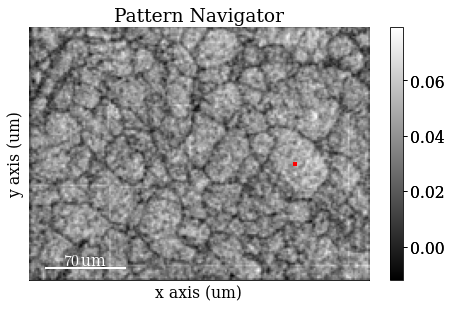

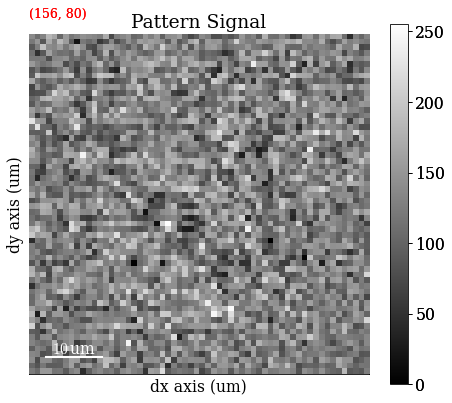

In [6]:
# Move the pointer programmatically to inside a large grain
s.axes_manager.indices = (156, 80)

s.plot(hs.signals.Signal2D(iq))

The image quality map is *very* noisy, but we might be able to convince ourselves that the darker lines are grain boundaries (they are).
The map is noisy because the patterns are noisy.
The pattern shown is from inside one of the larger grains on the right side of the map from the small red square (the pointer).
Even though the material is well recrystallized with appreciably large grains, the pattern is *very* noisy.
But again, we might be able to convince ourselves that there is some "correlated noise", e.g. a couple of zones axes (darker regions in the pattern) and some bands delineated by darker lines on each side of the band...

## Calibrate geometry

Seven calibration patterns of high quality was acquired prior to acquiring the full dataset above, in order to calibrate the sample-detector geometry.
The detector was mounted with 0$^{\circ}$, and we will assume that the nominal sample tilt of 70$^{\circ}$ is correct.
What remains then is to determine a plane of projection centers (PCs), one for each point in the full dataset.
Since we know the detector pixel size (~70 $\mu$m on the NORDIF UF-1100 detector), we can extrapolate this plane of PCs from a mean PC.
The workflow is the following:

1. Estimate PCs from an initial guess using Hough indexing
2. Hough indexing of calibration patterns using estimated PCs
3. Refine Hough indexed orientations and estimated PCs using pattern matching
4. Extrapolate plane of PCs from mean of refined PCs

After each step, we will evaluate our results.

Load calibration patterns

In [7]:
s_cal = kp.data.ni_gain_calibration(10)
s_cal

<EBSD, title: Calibration patterns, dimensions: (7|480, 480)>

Remove static and dynamic background

In [8]:
s_cal.remove_static_background()
s_cal.remove_dynamic_background()

[########################################] | 100% Completed | 101.31 ms
[########################################] | 100% Completed | 101.71 ms


Extract positions of calibration patterns on the sample surface (possibly outside the region of interest [ROI]) and the shape and position of the ROI relative to the area imaged in an overview secondary electron image.
This information is read with the calibration patterns from the NORDIF settings file.

In [9]:
omd = s_cal.original_metadata

Plot calibration pattern map locations

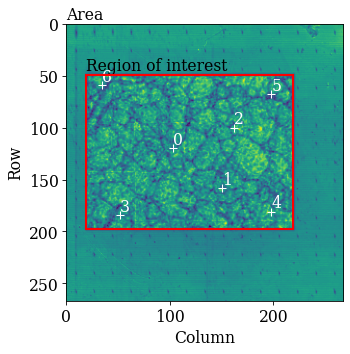

In [10]:
kp.draw.plot_pattern_positions_in_map(
    rc=omd.calibration_patterns.indices_scaled,
    roi_shape=omd.roi.shape_scaled,
    roi_origin=omd.roi.origin_scaled,
    roi_image=iq,
    area_shape=omd.area.shape_scaled,
    area_image=omd.area_image,
    color="w",
)

Hough indexing requires a phase list in order to make a look-up table of interplanar angles to compare the detected angles (from combinations of bands) to.
So far, Hough indexing only supports face-centered and body-centered cubic (FCC and BCC) materials (dictionary indexing and pattern matching support all crystallographic point groups).
See the [hough indexing tutorial](hough_indexing.ipynb) for more details.
Since we later on need a dynamically simulated master pattern of nickel (simulated with EMsoft), we will load this here and use the phase attached to this master pattern in the phase list.

<div class="alert alert-info">

Note

PyEBSDIndex is an optional dependency of kikuchipy, and can be installed with both `pip` and `conda` (from `conda-forge`).
To install PyEBSDIndex, see their [installation instructions](https://pyebsdindex.readthedocs.io/en/latest/user/installation.html).

</div>


In [11]:
# kikuchipy.data.nickel_ebsd_master_pattern_small() is an alternative
mp = kp.data.ebsd_master_pattern(
    "ni", allow_download=True, projection="lambert", energy=20
)
mp

<EBSDMasterPattern, title: ni_mc_mp_20kv, dimensions: (|1001, 1001)>

In [12]:
phase = mp.phase
phase

<name: ni. space group: Fm-3m. point group: m-3m. proper point group: 432. color: tab:blue>

Create a PyEBSDIndex indexer to use with Hough indexing.
We get this from our EBSD detector instance attached to the calibration pattern signal

In [13]:
det_cal = s_cal.detector
phase_list = PhaseList(phase)
indexer = det_cal.get_indexer(phase_list, rSigma=2, tSigma=2)

Estimate PCs from an initial guess based on previous experiments and print the mean and standard deviation

In [14]:
det_cal = s_cal.hough_indexing_optimize_pc(
    pc0=[0.4, 0.2, 0.5],
    indexer=indexer,
    batch=True,
    method="PSO",
)

print(det_cal.pc_flattened.mean(axis=0))
print(det_cal.pc_flattened.std(0))


PC found: [********* ] 7/7  global best:0.125  PC opt:[0.4276 0.2215 0.5109]
[0.41624213 0.21213569 0.50047161]
[0.01385959 0.00632393 0.00826701]


Compare the distribution of PCs to the above plotted map locations (especially PCx vs. PCy)

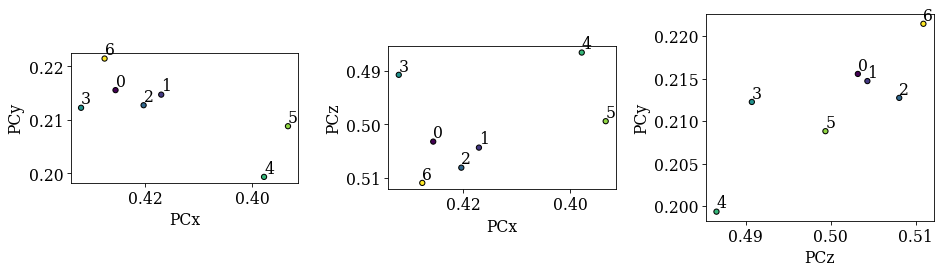

In [15]:
det_cal.plot_pc("scatter", annotate=True)

We see no direct correlation between the sample positions and the PCs.
Let's index the calibration patterns using these PCs and compare the solutions' band positions to the actual bands.
We update our indexer instance with the estimated PCs.

Hough indexing with PyEBSDIndex information:
  PyOpenCL: True
  Projection center (Bruker, mean): (0.4162, 0.2121, 0.5005)
  Indexing 7 pattern(s) in 1 chunk(s)
Radon Time: 0.03888994699991599
Convolution Time: 0.004178315999524784
Peak ID Time: 0.0017008570002872148
Band Label Time: 0.04188930700001947
Total Band Find Time: 0.08668588999989879
Band Vote Time:  0.013306317000569834
  Indexing speed: 56.28265 patterns/s


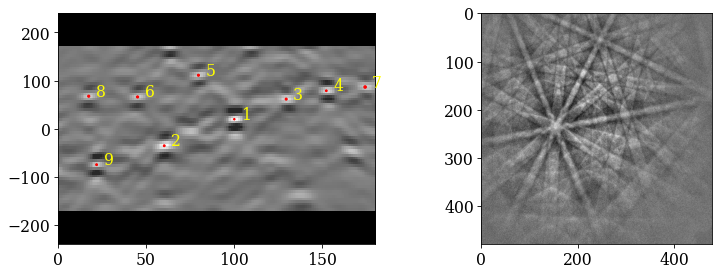

In [16]:
indexer.PC = det_cal.pc
xmap_cal = s_cal.hough_indexing(
    phase_list=phase_list, indexer=indexer, verbose=2
)

Check indexed orientations by plotting geometrical simulations on top of the patterns.
See the [tutorial on geometrical EBSD simulations](geometrical_ebsd_simulations.ipynb) for details.

In [17]:
rlv = ReciprocalLatticeVector.from_min_dspacing(phase.deepcopy(), 0.07)
rlv.sanitise_phase()  # "Fill atoms in unit cell"
rlv.calculate_structure_factor()
structure_factor = abs(rlv.structure_factor)
rlv = rlv[structure_factor > 0.12 * structure_factor.max()]
rlv.print_table()

 h k l      d     |F|_hkl   |F|^2   |F|^2_rel   Mult 
 1 1 1    0.203     0.4      0.2      100.0      8   
 2 0 0    0.176     0.3      0.1       60.9      6   
 2 2 0    0.125     0.1      0.0       8.7       12  
 3 1 1    0.106     0.1      0.0       2.0       24  


In [18]:
simulator = kp.simulations.KikuchiPatternSimulator(rlv)
sim_cal = simulator.on_detector(det_cal, xmap_cal.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 108.15 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 101.68 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 101.85 ms


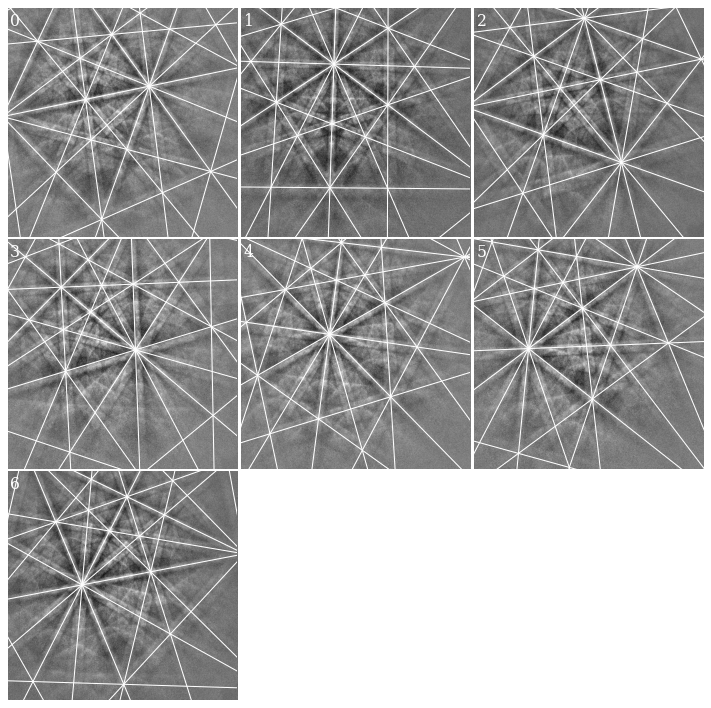

In [19]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(12, 12))
axes = axes.ravel()
for i in range(xmap_cal.size):
    axes[i].imshow(s_cal.inav[i].data, cmap="gray")
    lines = sim_cal.as_collections(i, lines_kwargs=dict(color="w"))[0]
    axes[i].add_collection(lines)
    axes[i].text(5, 10, i, c="w", va="top", ha="left")
_ = [a.axis("off") for a in axes]
fig.subplots_adjust(wspace=0.01, hspace=0.01)

Most lines align quite well with the bands.
Some of them, especially in the lower parts of the patterns and on wide bands, do not follow the band middle, though.
Let's refine these solutions using pattern matching

In [20]:
xmap_cal_ref, det_cal_ref = s_cal.refine_orientation_projection_center(
    xmap=xmap_cal,
    detector=det_cal,
    master_pattern=mp,
    energy=20,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5, 0.1, 0.1, 0.1],  # Sufficiently wide
    rtol=1e-5,
    # One pattern per iteration to utilize all CPUs
    chunk_kwargs=dict(chunk_shape=1),
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5.  5.  5.  0.1 0.1 0.1]
  Relative tolerance: 1e-05
Refining 7 orientation(s) and projection center(s):
[########################################] | 100% Completed | 31.93 ss
Refinement speed: 0.21919 patterns/s


Check quality metrics

In [21]:
print(xmap_cal_ref.scores.mean())
print(xmap_cal_ref.num_evals.mean())

0.5027272403240204
261.42857142857144


Check deviations from Hough indexed solutions (it is important that these deviations are well within our trust region above)

In [22]:
angles_cal = xmap_cal.orientations.angle_with(
    xmap_cal_ref.orientations, degrees=True
)
pc_dev_cal = det_cal.pc_flattened - det_cal_ref.pc_flattened

print(angles_cal)
print(abs(pc_dev_cal).max(0))

[0.85543925 0.61961995 0.51853644 1.38485825 2.21605052 2.27580859
 1.16130052]
[0.02283988 0.0122159  0.01493422]


Get geometrical simulations from refined orientations and PCs and add lines from these simulations (in red) to the existing figure

In [23]:
sim_cal_ref = simulator.on_detector(det_cal_ref, xmap_cal_ref.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 101.06 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 101.33 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 102.01 ms


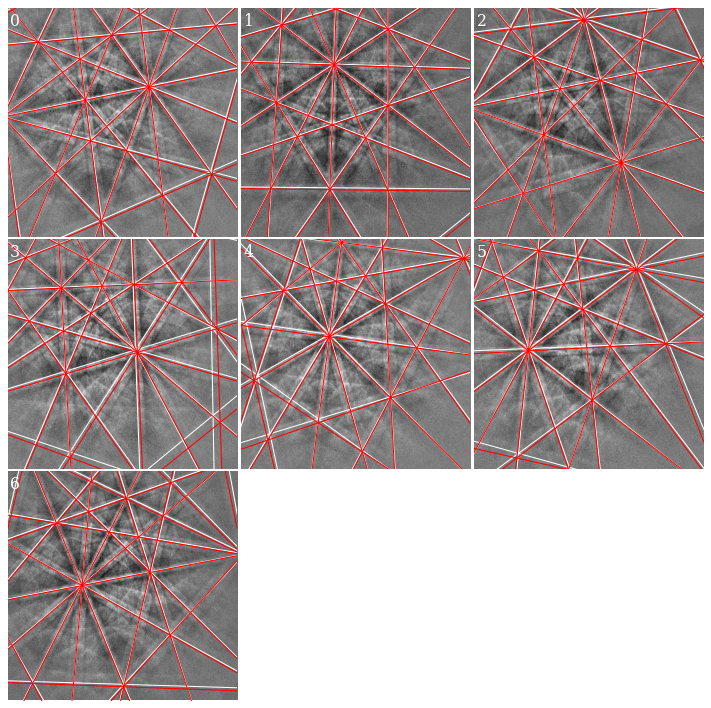

In [24]:
for i in range(xmap_cal_ref.size):
    lines = sim_cal_ref.as_collections(i)[0]
    axes[i].add_collection(lines)
fig

We see that the red lines align better with wider bands and bands in the lower part of the patterns (where the deviations are also greater).

Check the refined PCs

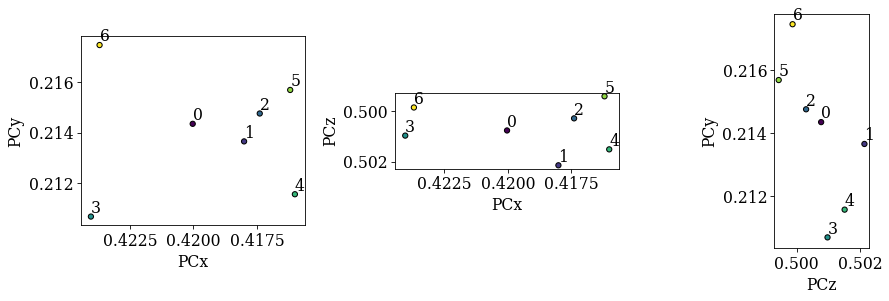

In [25]:
det_cal_ref.plot_pc("scatter", annotate=True)

We now see that the patterns align quite well compared to the sample positions.
We will therefore attempt to fit a plane to these PCs using an affine transformation (see the tutorial on [PC plane fitting](pc_fit_plane.ipynb) for more details).
Note that if the PCs hadn't aligned as nicely as here we would be better off extrapolating a plane of PCs from an average; this procedure is detailed in [another tutorial](pc_extrapolate_plane).

[0.4198254  0.21409426 0.50069019]
70.20920529607749
[0.0003456  0.00050963 0.00035804]


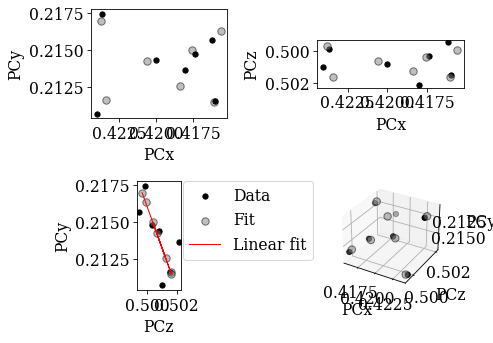

In [26]:
pc_indices = omd.calibration_patterns.indices_scaled.copy()
pc_indices -= omd.roi.origin_scaled
pc_indices = pc_indices.T

det_cal_fit = det_cal_ref.fit_pc(
    pc_indices,
    map_indices=np.indices(s.axes_manager.navigation_shape[::-1]),
    transformation="affine",
)
print(det_cal_fit.pc_average)

# Sample tilt
print(det_cal_fit.sample_tilt)

# Max. deviation between experimental and fitted PC
pc_diff_fit = det_cal_ref.pc - det_cal_fit.pc[tuple(pc_indices)]
print(abs(pc_diff_fit.reshape(-1, 3)).mean(axis=0))

Check the plane of PCs

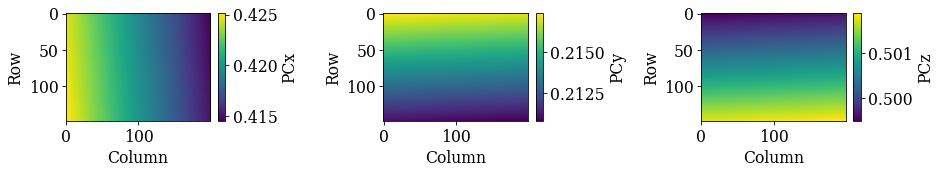

In [27]:
det_cal_fit.plot_pc()

As a final evaluation of this plane of PCs, we will refine the (refined) orientations using a fixed PC for each pattern taken from the plane of PCs

In [28]:
det_cal_fit2 = det_cal_fit.deepcopy()
det_cal_fit2.pc = det_cal_fit2.pc[tuple(pc_indices)]

In [29]:
xmap_cal_ref2 = s_cal.refine_orientation(
    xmap=xmap_cal_ref,
    detector=det_cal_fit2,
    master_pattern=mp,
    energy=20,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5],
    chunk_kwargs=dict(chunk_shape=1),
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5 5 5]
  Relative tolerance: 0.0001
Refining 7 orientation(s):
[########################################] | 100% Completed | 5.10 sms
Refinement speed: 1.36935 patterns/s


In [30]:
print(xmap_cal_ref2.scores.mean())
print(xmap_cal_ref2.num_evals.mean())

0.5026137105056218
61.142857142857146


In [31]:
angles_cal2 = xmap_cal_ref.orientations.angle_with(
    xmap_cal_ref2.orientations, degrees=True
)
print(angles_cal2)

[0.20629373 0.10605791 0.22602235 0.31406483 0.19643774 0.27942653
 0.15434019]


Get geometrical simulations and add a third set of lines (in blue) to the existing figure

In [32]:
sim_cal_ref2 = simulator.on_detector(det_cal_fit2, xmap_cal_ref2.rotations)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 101.49 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 101.57 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 104.94 ms


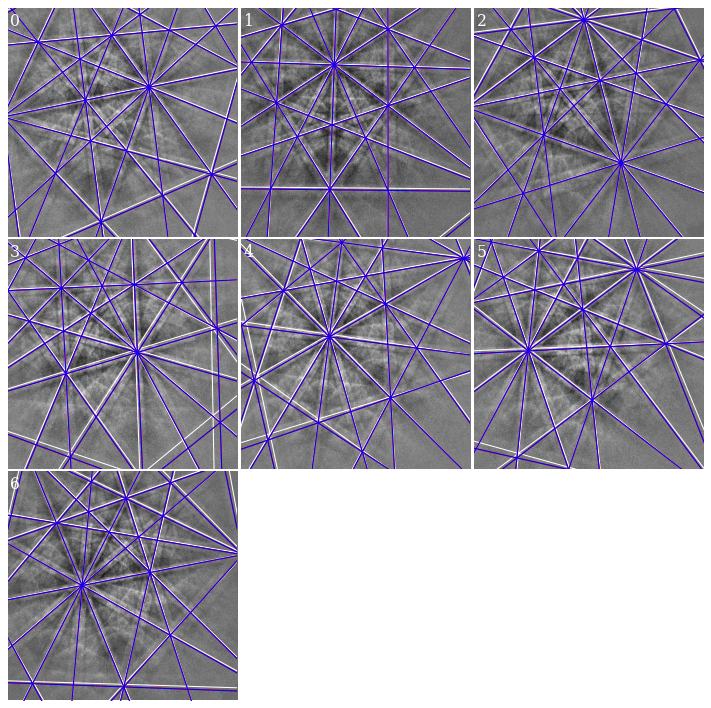

In [33]:
for i in range(xmap_cal_ref2.size):
    lines = sim_cal_ref2.as_collections(i, lines_kwargs=dict(color="b"))[0]
    axes[i].add_collection(lines)
fig

## Hough indexing of all patterns

Now that we are confident of our geometry calibration, we can index all patterns in our noisy experimental dataset.

Copy the detector with the calibrated PCs and update the detector shape to match our experimental patterns

In [34]:
det = det_cal_fit.deepcopy()
det.shape = s.detector.shape
det

EBSDDetector (60, 60), px_size 1 um, binning 1, tilt 0.0, azimuthal 0, pc (0.42, 0.214, 0.501)

Get a new indexer

In [35]:
indexer = det.get_indexer(phase_list, rSigma=2, tSigma=2)

Perform Hough indexing with PyEBSDIndex (using the GPU via PyOpenCL, but only a single CPU)

Hough indexing with PyEBSDIndex information:
  PyOpenCL: True
  Projection center (Bruker, mean): (0.4198, 0.2141, 0.5007)
  Indexing 29800 pattern(s) in 57 chunk(s)
Radon Time: 2.2274118479990648
Convolution Time: 3.4986441209939585
Peak ID Time: 2.625144092001392
Band Label Time: 4.551146314998732
Total Band Find Time: 12.90294119400005
Band Vote Time:  16.04134638799951
  Indexing speed: 1025.59319 patterns/s


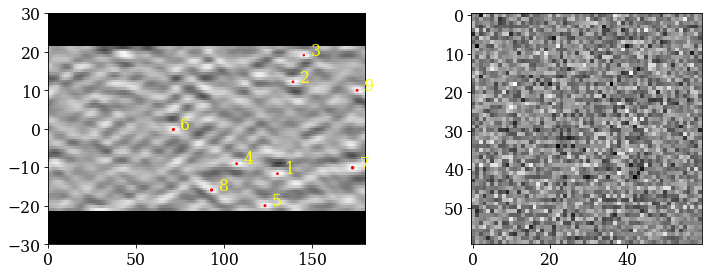

In [36]:
xmap_hi = s.hough_indexing(phase_list=phase_list, indexer=indexer, verbose=2)

Our use of PyEBSDIndex here gave indexing of > 1000 patterns/s.

<div class="alert alert-info">

Note

Note that PyEBSDIndex can index a lot faster than this by using more CPUs and by passing a file directly (not via NumPy or Dask arrays, as done here) to its indexing functions.
See its documentation for details: https://pyebsdindex.readthedocs.io/en/latest.

</div>

In [37]:
xmap_hi

Phase    Orientations         Name  Space group  Point group  Proper point group     Color
   -1     1102 (3.7%)  not_indexed         None         None                None         w
    0   28698 (96.3%)           ni        Fm-3m         m-3m                 432  tab:blue
Properties: fit, cm, pq, nmatch
Scan unit: um

In [38]:
# Save HI map
# io.save("xmap_hi.h5", xmap_hi)

PyEBSDIndex couldn't index some 4% of patterns (pattern fit above 3$^{\circ}$).
Let's check the quality metrics (pattern fit, confidence metric, pattern quality and the number of detected bands labeled)

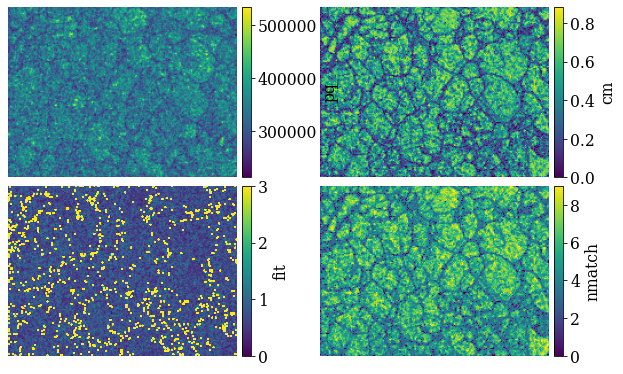

In [39]:
aspect_ratio = xmap_hi.shape[1] / xmap_hi.shape[0]
figsize = (8 * aspect_ratio, 4.5 * aspect_ratio)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)
for a, to_plot in zip(ax.ravel(), ["pq", "cm", "fit", "nmatch"]):
    if to_plot == "fit":
        im = a.imshow(xmap_hi.get_map_data(to_plot), vmin=0, vmax=3)
    else:
        im = a.imshow(xmap_hi.get_map_data(to_plot))
    fig.colorbar(im, ax=a, label=to_plot, pad=0.02)
    a.axis("off")
fig.subplots_adjust(wspace=0, hspace=0.05)

The bright points in the lower left pattern fit map are the points considered not indexed.
The confidence metric and number of successfully labeled bands (out of nine) seem to be highest within grains and lowest at grain boundaries.
Let's inspect the spatial variation of "successfully" indexed orientations in an inverse pole figure map (IPF-X)

In [40]:
sym = xmap_hi.phases[0].point_group
ckey = plot.IPFColorKeyTSL(sym, Vector3d([1, 0, 0]))
ckey

IPFColorKeyTSL, symmetry: m-3m, direction: [1 0 0]

/home/hakon/miniconda3/envs/kp-dev/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


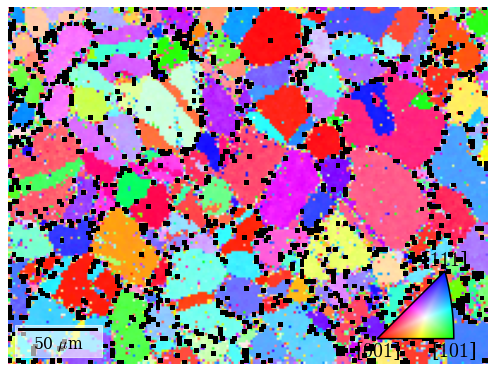

In [41]:
rgb_hi = ckey.orientation2color(xmap_hi["indexed"].rotations)
fig = xmap_hi["indexed"].plot(
    rgb_hi, remove_padding=True, return_figure=True
)

# Place color key in bottom right corner, coordinates are
# [left, bottom, width, height]
ax_ckey = fig.add_axes(
    [0.75, 0.07, 0.2, 0.2], projection="ipf", symmetry=sym
)
ax_ckey.plot_ipf_color_key(show_title=False)
ax_ckey.patch.set_facecolor("None")

Many points seen as single color deviations from otherwise smooth colors within recrystallized grains are located mostly at grain boundaries.

## Identify points for re-indexing

Let's see if we can easily separate the good from bad points using any of the quality metrics

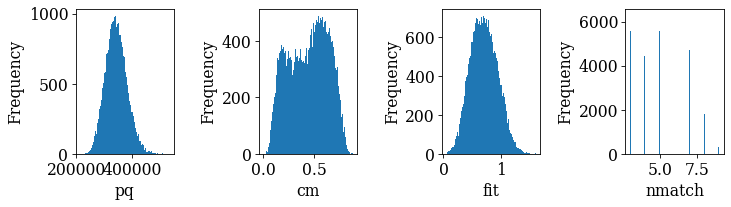

In [42]:
fig, ax = plt.subplots(ncols=4, figsize=(10, 3))
for a, to_plot in zip(ax.ravel(), ["pq", "cm", "fit", "nmatch"]):
    _ = a.hist(xmap_hi["indexed"].prop[to_plot], bins=100)
    a.set(xlabel=to_plot, ylabel="Frequency")
fig.tight_layout()

... hm, there is no clear bimodal distribution in any of the histograms.
It is recommended to find the "good" and "bad" points by trial-and-error until a desired separation is achieved.
Here, we have combined metrics by trial-and-error to get a plausible separation, but note that other combinations might be better for other datasets.

Fraction to re-index: 43.39%


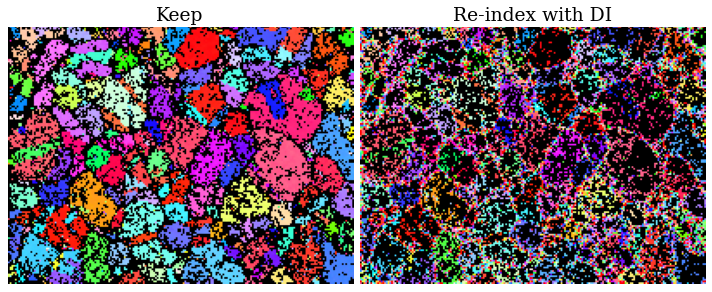

In [43]:
mask_reindex = np.logical_or.reduce(
    (
        ~xmap_hi.is_indexed,
        xmap_hi.fit > 0.9,
        xmap_hi.nmatch < 4,
        xmap_hi.cm < 0.25,
    )
)
frac_reindex = mask_reindex.sum() / mask_reindex.size
print(f"Fraction to re-index: {100 * frac_reindex:.2f}%")

# Get colors for all points, even the ones considered not-indexed
rgb_hi_all = ckey.orientation2color(xmap_hi.rotations)

# Get separate arrays for points to keep and to re-index, with in the other
# array as black
rgb_hi_reindex = np.zeros((xmap_hi.size, 3))
rgb_hi_keep = np.zeros_like(rgb_hi_reindex)
rgb_hi_reindex[mask_reindex] = rgb_hi_all[mask_reindex]
rgb_hi_keep[~mask_reindex] = rgb_hi_all[~mask_reindex]

nav_shape = xmap_hi.shape + (3,)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))
ax0.imshow(rgb_hi_keep.reshape(nav_shape))
ax1.imshow(rgb_hi_reindex.reshape(nav_shape))
for a, title in zip([ax0, ax1], ["Keep", "Re-index with DI"]):
    a.axis("off")
    a.set_title(title)
fig.subplots_adjust(wspace=0.02)

There are some spurious points still left among the points to keep, otherwise the orientation map looks fairly convincing.

Make navigation mask 2D.
Points to re-index are set to `False`.

In [44]:
nav_mask = np.ones(xmap_hi.size, dtype=bool)
nav_mask[mask_reindex] = False
nav_mask = nav_mask.reshape(xmap_hi.shape)

## Re-indexing with dictionary indexing

To generate the dictionary of Ni patterns, we need to sample the orientation space at a sufficiently high resolution (here 2$^{\circ}$) with a fixed calibration geometry (PC).
See the [pattern matching tutorial](pattern_matching.ipynb) for details.

In [45]:
rot = sampling.get_sample_fundamental(resolution=2, point_group=sym)
rot

Rotation (100347,)
[[ 0.8541 -0.3536 -0.3536 -0.1435]
 [ 0.8541 -0.3536 -0.3536  0.1435]
 [ 0.8541 -0.3536 -0.1435 -0.3536]
 ...
 [ 0.8541  0.3536  0.1435  0.3536]
 [ 0.8541  0.3536  0.3536 -0.1435]
 [ 0.8541  0.3536  0.3536  0.1435]]

In [46]:
det_pc1 = det.deepcopy()
det_pc1.pc = det_pc1.pc_average

det_pc1.pc

array([[0.4198254 , 0.21409426, 0.50069019]])

In [47]:
sim = mp.get_patterns(
    rotations=rot,
    detector=det_pc1,
    energy=20,
    chunk_shape=rot.size // 15,
)
sim

<LazyEBSD, title: , dimensions: (100347|60, 60)>

We only match the intensities within a circular mask (note the inversion!)

In [48]:
signal_mask = kp.filters.Window("circular", det.shape).astype(bool)
signal_mask = ~signal_mask

Perform dictionary indexing of the patterns and intensities marked as `False` in the navigation and signal masks

In [49]:
xmap_di = s.dictionary_indexing(
    sim,
    keep_n=1,
    navigation_mask=nav_mask,
    signal_mask=signal_mask,
)

Dictionary indexing information:
  Phase name: ni
  Matching 12931/29800 experimental pattern(s) to 100347 dictionary pattern(s)
  NormalizedCrossCorrelationMetric: float32, greater is better, rechunk: False, navigation mask: True, signal mask: True


100%|████████████████████████████████████████████████████████████████████| 16/16 [01:36<00:00,  6.01s/it]


  Indexing speed: 134.36582 patterns/s, 13483206.56989 comparisons/s


In [50]:
# Save DI map
# io.save("xmap_di.h5", xmap_di)

We see that HI is about 7-8x faster than DI.

In [51]:
xmap_di.scores.mean()

0.16069281

/home/hakon/miniconda3/envs/kp-dev/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


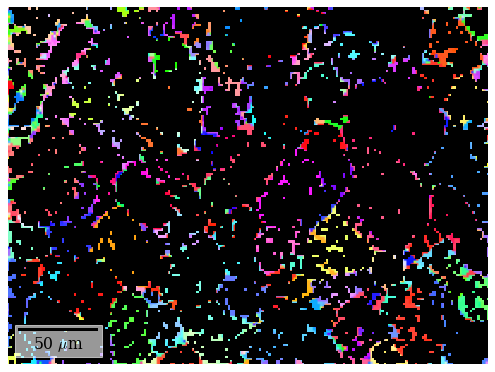

In [52]:
rgb_di = ckey.orientation2color(xmap_di.rotations)
fig = xmap_di.plot(rgb_di, remove_padding=True, return_figure=True)

An average correlation score of about 0.15 is low, but OK since we can refine the solutions and would expect a higher score from this.
The orientation map looks plausible, though, which it did not from these patterns after HI.

## Refine Hough indexed and dictionary indexed points

First we specify common refinement parameters, so that the scores obtain can be compared.
This is *very* important!

In [53]:
ref_kw = dict(
    detector=det,
    master_pattern=mp,
    energy=20,
    signal_mask=signal_mask,
    method="LN_NELDERMEAD",
    trust_region=[5, 5, 5],
)

Of the Hough indexed solutions, we only want to refine those that are not re-indexed using dictionary indexing.
We therefore pass the navigation mask, but have to take care to set those points that we want to index to `False`

In [54]:
xmap_hi_ref = s.refine_orientation(
    xmap=xmap_hi, navigation_mask=~nav_mask, **ref_kw
)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5 5 5]
  Relative tolerance: 0.0001
Refining 16869 orientation(s):
[########################################] | 100% Completed | 118.77 s
Refinement speed: 141.97199 patterns/s


In [55]:
print(xmap_hi_ref.scores.mean())
print(xmap_hi_ref.num_evals.max())

0.24424716648052477
189


An average correlation score of about 0.25 is OK.

We now refine the re-indexed points.
No navigation mask is necessary, since the crystal map returned from DI has a mask keeping track of which points are "in the data" via [CrystalMap.is_in_data](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.CrystalMap.html).

In [56]:
xmap_di_ref = s.refine_orientation(xmap=xmap_di, **ref_kw)

Refinement information:
  Method: LN_NELDERMEAD (local) from NLopt
  Trust region (+/-): [5 5 5]
  Relative tolerance: 0.0001
Refining 12931 orientation(s):
[########################################] | 100% Completed | 91.58 ss
Refinement speed: 141.13347 patterns/s


In [57]:
print(xmap_di_ref.scores.mean())
print(xmap_di_ref.num_evals.max())

0.20479310112116222
186


An average correlation score of about 0.20 is still OK.

## Merge results

We can now merge the results, taking care to pass the navigation mask where each refined map should be considered.
Since only the points not in the refined HI map were indexed with DI, the same mask can be used in both cases.

In [58]:
xmap_ref = kp.indexing.merge_crystal_maps(
    [xmap_hi_ref, xmap_di_ref], navigation_masks=[~nav_mask, nav_mask]
)

In [59]:
xmap_ref

Phase    Orientations  Name  Space group  Point group  Proper point group     Color
    0  29800 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores, merged_scores
Scan unit: um

We see that we have a complete map for all our points!

In [60]:
# Save final refined combined map
# io.save("xmap_ref.h5", xmap_ref)

## Evaluate results

Finally, we can compare the IPF-X maps with HI only and after re-indexing, refinement and combination

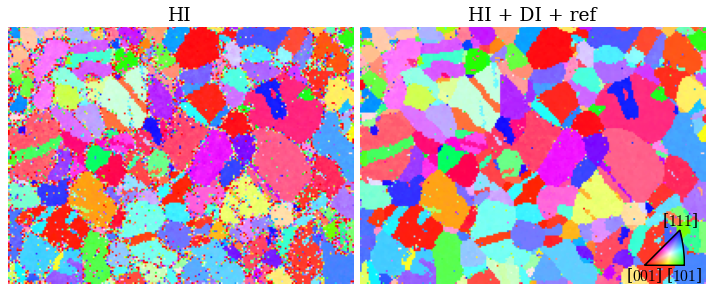

In [61]:
rgb_ref = ckey.orientation2color(xmap_ref.orientations)
rgb_shape = xmap_ref.shape + (3,)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))
ax0.imshow(rgb_hi_all.reshape(rgb_shape))
ax1.imshow(rgb_ref.reshape(rgb_shape))
for a, title in zip([ax0, ax1], ["HI", "HI + DI + ref"]):
    a.axis("off")
    a.set_title(title)

ax_ckey = fig.add_axes(
    [0.805, 0.2, 0.1, 0.1], projection="ipf", symmetry=sym
)
ax_ckey.plot_ipf_color_key(show_title=False)
ax_ckey.patch.set_facecolor("None")
_ = [t.set_fontsize(15) for t in ax_ckey.texts]

fig.subplots_adjust(wspace=0.02)

We extract a grid of patterns and plot the geometrical simulations on top of these patterns

In [62]:
s.xmap = xmap_ref
s.detector = det

In [63]:
grid_shape = (4, 4)
s_grid, idx = s.extract_grid(grid_shape, return_indices=True)

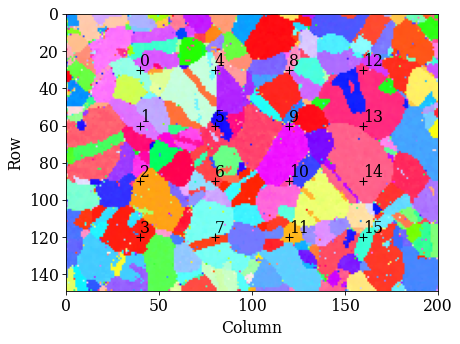

In [64]:
kp.draw.plot_pattern_positions_in_map(
    rc=idx.T.reshape((-1, 2)),
    roi_shape=xmap_ref.shape,
    roi_image=rgb_ref.reshape(rgb_shape),
)

In [65]:
sim_grid = simulator.on_detector(
    s_grid.detector, s_grid.xmap.rotations.reshape(*grid_shape)
)

Finding bands that are in some pattern:
[########################################] | 100% Completed | 101.27 ms
Finding zone axes that are in some pattern:
[########################################] | 100% Completed | 101.77 ms
Calculating detector coordinates for bands and zone axes:
[########################################] | 100% Completed | 102.20 ms


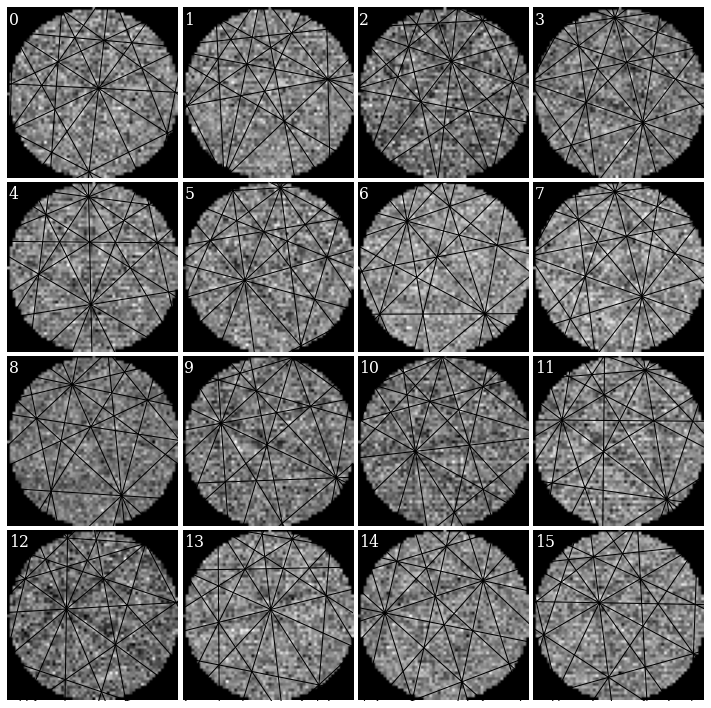

In [66]:
fig, axes = plt.subplots(
    nrows=grid_shape[0], ncols=grid_shape[1], figsize=(12, 12)
)
for idx in np.ndindex(grid_shape):
    ax = axes[idx]
    ax.imshow(s_grid.data[idx] * ~signal_mask, cmap="gray")
    lines = sim_grid.as_collections(idx, lines_kwargs=dict(color="k"))[0]
    ax.add_collection(lines)
    ax.axis("off")
    ax.text(
        0,
        1,
        np.ravel_multi_index(idx, grid_shape),
        va="top",
        ha="left",
        c="w",
    )
fig.subplots_adjust(wspace=0.02, hspace=0.02)

It's difficult to see any bands in these *very* noisy patterns...
There at least seems to be a correlation between darker regions in the patterns (not the corners) and zone axes, which is expected.

In conclusion, by combining the speed of Hough indexing with the robustness towards noise of dictionary indexing, a dataset can be indexed in a shorter time and achieve about the same results as with DI (and refinement) only.